# L6: Multimodal Recommender System

<p style="background-color:#fff6e4; padding:15px; border-width:3px; border-color:#f5ecda; border-style:solid; border-radius:6px"> ⏳ <b>Note <code>(Kernel Starting)</code>:</b> This notebook takes about 30 seconds to be ready to use. You may start and watch the video while you wait.</p>

* In this classroom, the libraries have been already installed for you.
* If you would like to run this code on your own machine, you need to install the following:
```
    !pip install -U weaviate-client
    !pip install google-generativeai
    !pip install openai
```

In [1]:
import warnings
warnings.filterwarnings("ignore")

## Setup
### Load environment variables and API keys

In [2]:
import os
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file

MM_EMBEDDING_API_KEY = os.getenv("EMBEDDING_API_KEY")
TEXT_EMBEDDING_API_KEY = os.getenv("OPENAI_API_KEY")
OPENAI_BASEURL = os.getenv("OPENAI_BASE_URL")

## Connect to Weaviate

In [3]:
import weaviate

client = weaviate.connect_to_embedded(
    version="1.24.4",
    environment_variables={
        "ENABLE_MODULES": "multi2vec-palm,text2vec-openai"
    },
    headers={
        "X-PALM-Api-Key": MM_EMBEDDING_API_KEY,
        "X-OpenAI-Api-Key": TEXT_EMBEDDING_API_KEY,
        "X-OpenAI-BaseURL": OPENAI_BASEURL
    }
)

client.is_ready()

Started /home/jovyan/.cache/weaviate-embedded: process ID 161


{"action":"startup","default_vectorizer_module":"none","level":"info","msg":"the default vectorizer modules is set to \"none\", as a result all new schema classes without an explicit vectorizer setting, will use this vectorizer","time":"2025-08-27T18:34:38Z"}
{"action":"startup","auto_schema_enabled":true,"level":"info","msg":"auto schema enabled setting is set to \"true\"","time":"2025-08-27T18:34:38Z"}
{"level":"info","msg":"No resource limits set, weaviate will use all available memory and CPU. To limit resources, set LIMIT_RESOURCES=true","time":"2025-08-27T18:34:38Z"}
{"level":"warning","msg":"Multiple vector spaces are present, GraphQL Explore and REST API list objects endpoint module include params has been disabled as a result.","time":"2025-08-27T18:34:38Z"}
{"action":"grpc_startup","level":"info","msg":"grpc server listening at [::]:50050","time":"2025-08-27T18:34:38Z"}
{"action":"restapi_management","level":"info","msg":"Serving weaviate at http://127.0.0.1:8079","time":"202

True

## Create Multivector collection

In [4]:
from weaviate.classes.config import Configure, DataType, Property

# client.collections.delete("Movies")
client.collections.create(
    name="Movies",
    properties=[
        Property(name="title", data_type=DataType.TEXT),
        Property(name="overview", data_type=DataType.TEXT),
        Property(name="vote_average", data_type=DataType.NUMBER),
        Property(name="release_year", data_type=DataType.INT),
        Property(name="tmdb_id", data_type=DataType.INT),
        Property(name="poster", data_type=DataType.BLOB),
        Property(name="poster_path", data_type=DataType.TEXT),
    ],

   # Define & configure the vector spaces
    vectorizer_config=[
        # Vectorize the movie title and overview – for text-based semantic search
        Configure.NamedVectors.text2vec_openai(
            name="txt_vector",                       # the name of the txt vector space
            source_properties=["title", "overview"], # text properties to be used for vectorization
        ),
        
        # Vectorize the movie poster – for image-based semantic search
        Configure.NamedVectors.multi2vec_palm(
            name="poster_vector",                    # the name of the image vector space
            image_fields=["poster"],                 # use poster property multivec vectorization
            
            project_id="semi-random-dev",
            location="us-central1",
            model_id="multimodalembedding@001",
            dimensions=1408,
        ),
    ]
)

UnexpectedStatusCodeError: Collection may not have been created properly.! Unexpected status code: 422, with response body: {'error': [{'message': 'class name "Movies" already exists'}]}.

{"action":"telemetry_push","level":"info","msg":"telemetry started","payload":"\u0026{MachineID:7d53be6b-8940-4338-b7d4-ac0f9912ae72 Type:INIT Version:1.24.4 Modules:multi2vec-palm,text2vec-openai NumObjects:0 OS:linux Arch:amd64}","time":"2025-08-27T18:34:39Z"}
{"action":"hnsw_vector_cache_prefill","count":3000,"index_id":"vectors_poster_vector","level":"info","limit":1000000000000,"msg":"prefilled vector cache","time":"2025-08-27T18:34:39Z","took":55337}
{"level":"info","msg":"Completed loading shard movies_p60v7BnZwmdU in 1.128263ms","time":"2025-08-27T18:34:39Z"}
{"action":"hnsw_vector_cache_prefill","count":3000,"index_id":"vectors_txt_vector","level":"info","limit":1000000000000,"msg":"prefilled vector cache","time":"2025-08-27T18:34:39Z","took":46806}


## Load in data

<p style="background-color:#fff6ff; padding:15px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px"> 💻 &nbsp; <b>Access Files and Helper Functions:</b> To access the files for this notebook, 1) click on the <em>"File"</em> option on the top menu of the notebook and then 2) click on <em>"Open"</em>. For more help, please see the <em>"Appendix - Tips and Help"</em> Lesson.</p>


In [5]:
import pandas as pd
df = pd.read_json("movies_data.json")
df.head()

,backdrop_path,genre_ids,id,original_language,original_title,overview,popularity,poster_path,release_date,title,video,vote_average,vote_count
0,/3Nn5BOM1EVw1IYrv6MsbOS6N1Ol.jpg,"[14, 18, 10749]",162,en,Edward Scissorhands,A small suburban town receives a visit from a ...,45.694,/1RFIbuW9Z3eN9Oxw2KaQG5DfLmD.jpg,1990-12-07,Edward Scissorhands,False,7.7,12305
1,/nOTOC2J4DyySEuJIB2ySej0kk9u.jpg,"[10751, 35]",11806,en,Beethoven,The Newton family live in their comfortable ho...,25.541,/mVb3r5ZOeopEbCbx6kuIAjUz20F.jpg,1992-04-03,Beethoven,False,5.8,1950
2,/xWT5F1DNxciNLEMXRl49iq8zvN7.jpg,"[14, 16, 10751]",9479,en,The Nightmare Before Christmas,Tired of scaring humans every October 31 with ...,48.968,/oQffRNjK8e19rF7xVYEN8ew0j7b.jpg,1993-10-09,The Nightmare Before Christmas,False,7.8,8920
3,/c4Fl1cWiXcq4uJdOQudQClFjhho.jpg,"[14, 35, 10751]",10439,en,Hocus Pocus,"After 300 years of slumber, three sister witch...",32.808,/by4D4Q9NlUjFSEUA1yrxq6ksXmk.jpg,1993-07-16,Hocus Pocus,False,7.0,2819
4,/4PPC7fKClu0u7NTbo5xgV4vb5VD.jpg,"[80, 27, 9648]",4232,en,Scream,"A year after the murder of her mother, Sidney ...",42.734,/aXAByjBN8UhaYvotqRCwa5MsMGu.jpg,1996-12-20,Scream,False,7.4,6458


## Helper function

In [6]:
import base64

# Helper function to convert a file to base64 representation
def toBase64(path):
    with open(path, 'rb') as file:
        return base64.b64encode(file.read()).decode('utf-8')

## Import text and image data

In [7]:
from weaviate.util import generate_uuid5

movies = client.collections.get("Movies")

with movies.batch.rate_limit(20) as batch:
    # for index, movie in df.sample(20).iterrows():
    for index, movie in df.iterrows():

        # In case you run it again - Don't import movies that are already in.
        if(movies.data.exists(generate_uuid5(movie.id))):
            print(f'{index}: Skipping insert. The movie "{movie.title}" is already in the database.')
            continue

        print(f'{index}: Adding "{movie.title}"')

        # construct the path to the poster image file
        poster_path = f"./posters/{movie.id}_poster.jpg"
        # generate base64 representation of the poster
        posterb64 = toBase64(poster_path)

        # Build the object payload
        movie_obj = {
            "title": movie.title,
            "overview": movie.overview,
            "vote_average": movie.vote_average,
            "tmdb_id": movie.id,
            "poster_path": poster_path,
            "poster": posterb64
        }

        # Add object to batch queue
        batch.add_object(
            properties=movie_obj,
            uuid=generate_uuid5(movie.id),
        )

0: Adding "Edward Scissorhands"
1: Adding "Beethoven"
2: Adding "The Nightmare Before Christmas"
3: Adding "Hocus Pocus"
4: Adding "Scream"
5: Adding "101 Dalmatians"
6: Adding "A Bug's Life"
7: Adding "Stuart Little"
8: Adding "Chicken Run"
9: Adding "Ice Age"
10: Adding "Lilo & Stitch"
11: Adding "Iron Man"
12: Adding "The Incredible Hulk"
13: Adding "Man of Steel"
14: Adding "Captain America: Civil War"
15: Adding "Batman v Superman: Dawn of Justice"
16: Adding "A Quiet Place"
17: Adding "Incredibles 2"
18: Adding "Shazam!"
19: Adding "Evil Dead Rise"


In [8]:
# Check for failed objects
if len(movies.batch.failed_objects) > 0:
    print(f"Failed to import {len(movies.batch.failed_objects)} objects")
    for failed in movies.batch.failed_objects:
        print(f"e.g. Failed to import object with error: {failed.message}")
else:
    print("Import complete with no errors")

Failed to import 20 objects
e.g. Failed to import object with error: vectorize target vector poster_vector: update vector: connection to Google PaLM failed with status: 401 error: Request had invalid authentication credentials. Expected OAuth 2 access token, login cookie or other valid authentication credential. See https://developers.google.com/identity/sign-in/web/devconsole-project.
e.g. Failed to import object with error: vectorize target vector poster_vector: update vector: connection to Google PaLM failed with status: 401 error: Request had invalid authentication credentials. Expected OAuth 2 access token, login cookie or other valid authentication credential. See https://developers.google.com/identity/sign-in/web/devconsole-project.
e.g. Failed to import object with error: vectorize target vector poster_vector: update vector: connection to Google PaLM failed with status: 401 error: Request had invalid authentication credentials. Expected OAuth 2 access token, login cookie or oth

## Text-search through the text vector space

In [9]:
from IPython.display import Image

response = movies.query.near_text(
    query="Movie about lovable cute pets",
    target_vector="txt_vector",  # Search in the txt_vector space
    limit=3,
)

# Inspect the response
for item in response.objects:
    print(item.properties["title"])
    print(item.properties["overview"])
    display(Image(item.properties["poster_path"], width=200))

In [10]:
# Perform query
response = movies.query.near_text(
    query="Epic super hero",
    target_vector="txt_vector",  # Search in the txt_vector space
    limit=3,
)

# Inspect the response
for item in response.objects:
    print(item.properties["title"])
    print(item.properties["overview"])
    display(Image(item.properties["poster_path"], width=200))

## Text-search through the posters vector space

In [11]:
# Perform query
response = movies.query.near_text(
    query="Movie about lovable cute pets",
    target_vector="poster_vector",  # Search in the poster_vector space
    limit=3,
)

# Inspect the response
for item in response.objects:
    print(item.properties["title"])
    print(item.properties["overview"])
    display(Image(item.properties["poster_path"], width=200))

WeaviateQueryError: Query call with protocol GRPC search failed with message explorer: get class: vectorize params: vectorize params: vectorize params: vectorize keywords: remote client vectorize: connection to Google PaLM failed with status: 401 error: Request had invalid authentication credentials. Expected OAuth 2 access token, login cookie or other valid authentication credential. See https://developers.google.com/identity/sign-in/web/devconsole-project..

In [12]:
# Perform query
response = movies.query.near_text(
    query="Epic super hero",
    target_vector="poster_vector",  # Search in the poster_vector space
    limit=3,
)

# Inspect the response
for item in response.objects:
    print(item.properties["title"])
    print(item.properties["overview"])
    display(Image(item.properties["poster_path"], width=200))

WeaviateQueryError: Query call with protocol GRPC search failed with message explorer: get class: vectorize params: vectorize params: vectorize params: vectorize keywords: remote client vectorize: connection to Google PaLM failed with status: 401 error: Request had invalid authentication credentials. Expected OAuth 2 access token, login cookie or other valid authentication credential. See https://developers.google.com/identity/sign-in/web/devconsole-project..

## Image-search through the posters vector space

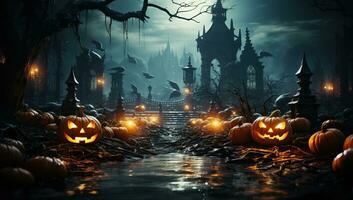

In [13]:
Image("test/spooky.jpg", width=300)

In [14]:
# Perform query
response = movies.query.near_image(
    near_image=toBase64("test/spooky.jpg"),
    target_vector="poster_vector",  # Search in the poster_vector space
    limit=3,
)

# Inspect the response
for item in response.objects:
    print(item.properties["title"])
    display(Image(item.properties["poster_path"], width=200))

WeaviateQueryError: Query call with protocol GRPC search failed with message explorer: get class: vectorize params: vectorize params: vectorize params: vectorize image: connection to Google PaLM failed with status: 401 error: Request had invalid authentication credentials. Expected OAuth 2 access token, login cookie or other valid authentication credential. See https://developers.google.com/identity/sign-in/web/devconsole-project..

#### One more example!

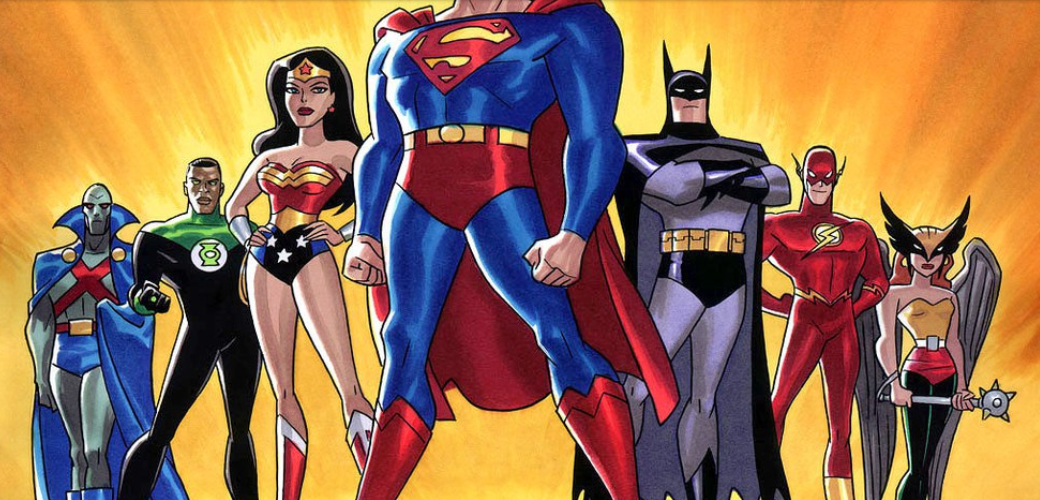

In [15]:
Image("test/superheroes.png", width=300)

In [ ]:
# Perform query
response = movies.query.near_image(
    near_image=toBase64("test/superheroes.png"),
    target_vector="poster_vector",  # Search in the poster_vector space
    limit=3,
)

# Inspect the response
for item in response.objects:
    print(item.properties["title"])
    display(Image(item.properties["poster_path"], width=200))

In [ ]:
client.close()